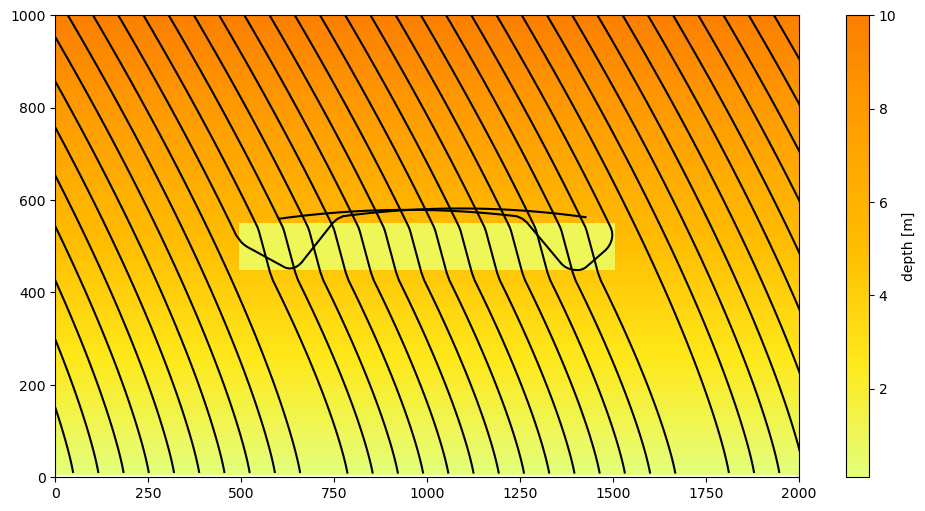

In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, '/Users/tpvan/Waves/ocean_wave_tracing')
from ocean_wave_tracing.ocean_wave_tracing import Wave_tracing

# Defining some properties of the medium
nx = 100; ny = 100 # number of grid points in x- and y-direction
x = np.linspace(0,2000,nx) # size x-domain [m]
y = np.linspace(0,1000,ny) # size y-domain [m]
T = 300 # simulation time [s]
U=np.zeros((ny,nx))
V=np.zeros((ny,nx))
# U[ny//2:,:]=1

rays=60

d_off = 10
d_bw = 1

d = np.ones((ny, nx)) * d_off

for i in range(ny):
    d[i, :] -= np.ones(nx) * d_off * (1 - i / (ny - 1))



d[int(ny//2-ny/20):int(ny//2+ny/20), int(nx//2-nx/4):int(nx//2+nx/4)] = np.ones((int(ny/10), int(nx/2))) * d_bw

# Define a wave tracing object
wt = Wave_tracing(U=U,V=V,
                       nx=nx, ny=ny, nt=100,T=T,
                       dx=x[1]-x[0],dy=y[1]-y[0],
                       nb_wave_rays=rays,
                       domain_X0=x[0], domain_XN=x[-1],
                       domain_Y0=y[0], domain_YN=y[-1],
                       d=d)

# Set initial conditions
wt.set_initial_condition(wave_period=10,
                          theta0=-0.3*np.pi, ipx=np.linspace(-2000, 2000, rays), ipy=np.ones(rays)*1000)

# Solve
wt.solve()

# Plot
fig, ax = plt.subplots(figsize=(12, 6));
# pc=ax.pcolormesh(wt.x,wt.y,wt.U.isel(time=0),shading='auto', cmap='Wistia')
pc=ax.pcolormesh(wt.x,wt.y,wt.d,shading='auto', cmap='Wistia')
dc=fig.colorbar(pc)
dc.set_label('depth [m]')

for ray_id in range(wt.nb_wave_rays):
    ax.plot(wt.ray_x[ray_id,:],wt.ray_y[ray_id,:],'-k')

plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())

# ax.quiver(x, y, U ,V)
plt.show()